# Ben Kim: GPR notebook (Master)
 Testing GPR on Simulation Data

 https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

In [ ]:
# Set up
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel
from sklearn.metrics import mean_absolute_error
import random
# np.random.seed(1226)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import requests
import time

In [ ]:
%%bash

while True:
    try:
        requests.get('https://www.google.com')
        print("Kept alive.")
    except:
        print("Failed to keep alive.")
    time.sleep(600)

bash: line 4: syntax error near unexpected token `'https://www.google.com''
bash: line 4: `        requests.get('https://www.google.com')'


CalledProcessError: ignored

In [ ]:
LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
LHS_data = pd.read_csv(LHS_url, index_col = 0)
LHS_data = LHS_data.reset_index()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_LHS = scaler.fit_transform(LHS_data)
scaled_LHS = pd.DataFrame(scaled_LHS)

In [ ]:
X = scaled_LHS.loc[:,0:13]
y = LHS_data['simulation_values']

# X = data[['t_final', 'h_tile', 'h_Ti', 'rho_tile', 'rho_Ti', 'cp_tile', 'cp_Ti',
#        'k_tile', 'k_Ti', 'emissivity', 'M_inf', 'p_inf', 'T_inf',
#        'fudge_factor']]

# y = data[['simulation_values']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # leave these values as are

In [ ]:
constant = 1 # not sure what this means

#length_scale_array = [10.1, 5.81, 21.2, 10.4, 23.5, 10.9, 28.3, 12.8, 29.9, 45.7, 9.01, 36.4, 17.7, 39.6]
length_scale_array = 1.0

kernel = constant * RBF(length_scale = length_scale_array, length_scale_bounds=(1e-2, 1e3)) # The RBF kernel with a large length-scale enforces this component to be smooth

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True) # No clue what the optimizer does

gpr.fit(X_train, y_train)

gpr.kernel_ # lets us see the tuned parameters

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


5.76**2 * RBF(length_scale=16)

In [ ]:
y_test

521    348.580154
737    354.305745
740    336.219464
660    329.401313
411    334.072461
          ...    
408    343.663536
332    356.877861
208    350.708116
613    363.468659
78     338.070363
Name: simulation_values, Length: 200, dtype: float64

In [ ]:
print('Performance Summary:')
print("GPR.score(): " + str(gpr.score(X, y)))
print("R-squared: "+str(r2_score(y_test, gpr.predict(X_test))))
print("MSE: "+ str(mean_squared_error(y_test, gpr.predict(X_test))))
#print("MAE train:" + str(mean_absolute_error(y_train, gpr.predict(X_train))))
print("MAE test:" + str(mean_absolute_error(y_test, gpr.predict(X_test))))

Performance Summary:
GPR.score(): 0.9999845020655445
R-squared: 0.9999239756569559
MSE: 0.02668330983861305
MAE test:0.1252866550332945


In [ ]:
scaler.var_

array([1.25297520e+01, 2.04001631e-06, 7.32363980e-11, 6.61961193e+01,
       6.85870362e+04, 1.23061727e+03, 6.81228418e+02, 5.23505790e-05,
       1.70340802e-01, 2.13732260e-03, 7.98169711e-02, 2.52914450e+04,
       2.75633400e+02, 3.14040150e-03, 3.26095981e+02])

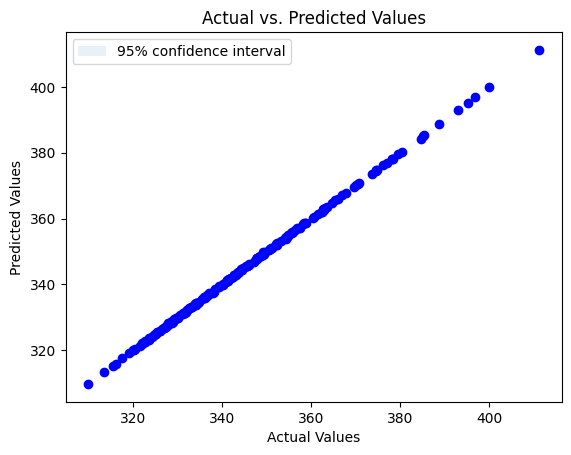

In [ ]:
mean_prediction, std_prediction = gpr.predict(X_test, return_std=True)

plt.scatter(y_test, mean_prediction, color='blue')

plt.fill_between(
    y_test,
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.1,
    label=r"95% confidence interval",
)

#plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

Okay, the GPR looks pretty good.

# Varying Sample Size (S)

Above we worked with a dataset of n = 1000. What happens with values of (0,1000)?


In [ ]:
sample_sizes = list(np.around((np.logspace(1, 2.7, 15)),0)) # USE LOGISTICAL SAMPLE SIZES
sample_sizes = [int(x) for x in sample_sizes]

In [ ]:
MSE_train = []
MSE_test = []

R2_train = []
R2_test = []

MAE_train = []
MAE_test = []
MAE_test_stds = []

def sample_test_func():
  for s in sample_sizes:

    indexes = random.sample(range(0, 1000), s)

    sample_data = scaled_LHS.loc[indexes]
    sample_y = LHS_data['simulation_values'].loc[indexes]

    X = sample_data.loc[:,0:13]
    y = sample_y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    constant = 1
    kernel = constant * RBF(length_scale=1, length_scale_bounds=(1e-3, 1e3))

    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)

    gpr.fit(X_train, y_train)

    y_train_pred = gpr.predict(X_train)
    y_test_pred = gpr.predict(X_test)

    MAE_train.append(mean_absolute_error(y_train, y_train_pred))
    MAE_test.append(mean_absolute_error(y_test, y_test_pred))

    MSE_train.append(mean_squared_error(y_train, y_train_pred))
    MSE_test.append(mean_squared_error(y_test, y_test_pred))


    R2_train.append(r2_score(y_train, y_train_pred))
    R2_test.append(r2_score(y_test, y_test_pred))

  print("Average MSE: "+str(np.mean(MSE_test)))
  print("Average MAE: "+str(np.mean(MAE_test)))

In [ ]:
sample_test_func()

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)

Average MSE: 42.99334063176842
Average MAE: 3.279381678261622


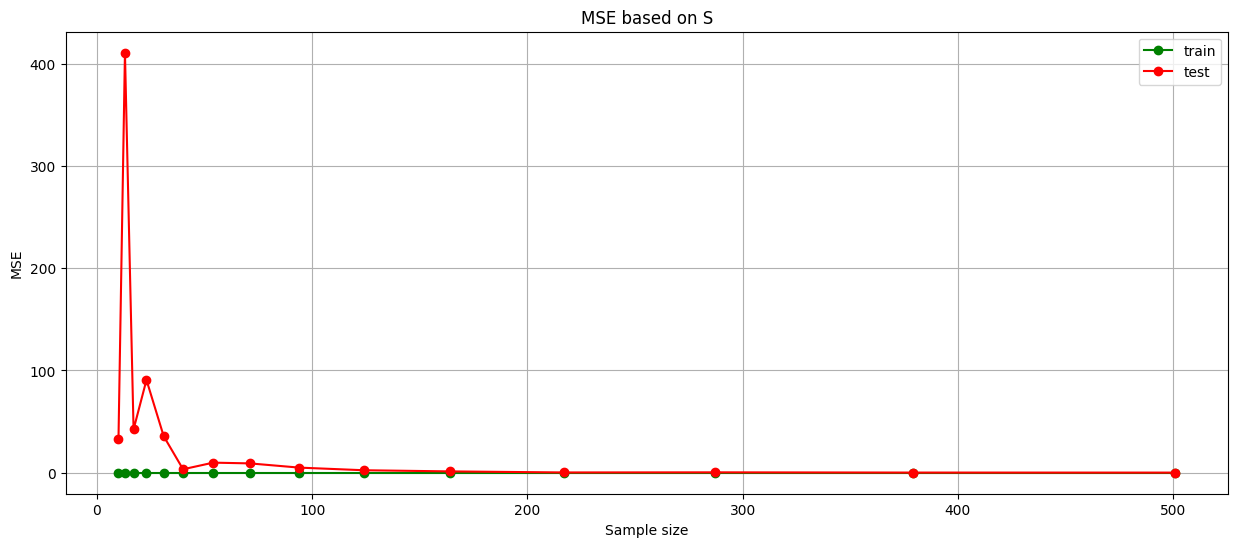

In [ ]:
# Plotting the MSE of the testng and training sets based off of sample size

plt.figure(figsize=(15,6))
plt.plot(sample_sizes, MSE_train, 'o-', color='green', label='train')
plt.plot(sample_sizes, MSE_test, 'o-', color='red', label='test')

plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel('MSE')
plt.title('MSE based on S')
plt.show()

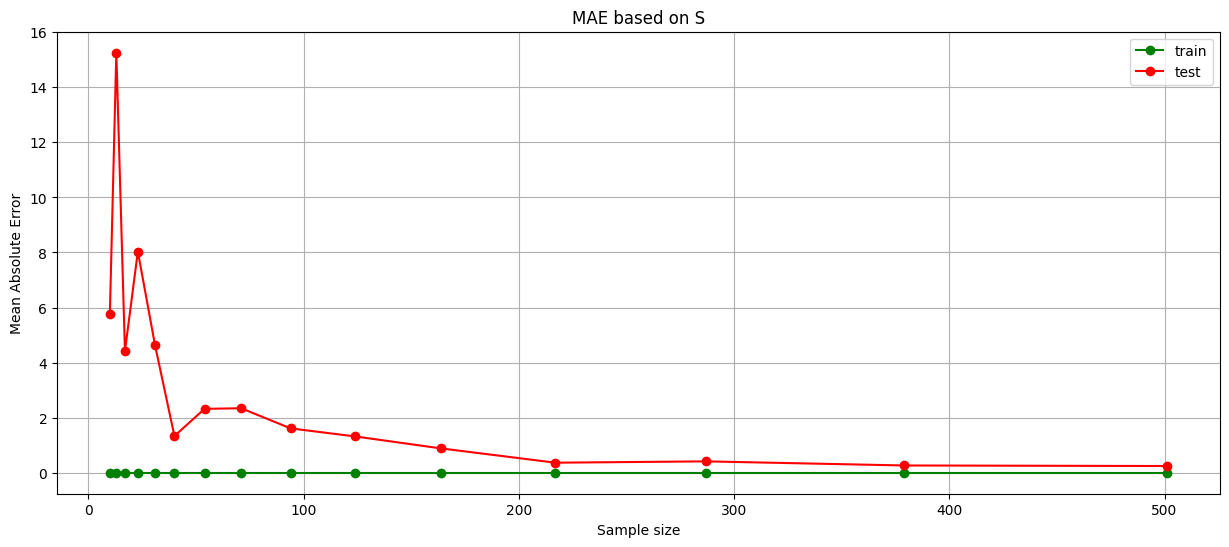

In [ ]:
# Plotting the MAE of the testng and training sets based off of sample size

plt.figure(figsize=(15,6))
plt.plot(sample_sizes, MAE_train, 'o-', color='green', label='train')
plt.plot(sample_sizes, MAE_test, 'o-', color='red', label='test')

# plt.fill_between(
#     sample_sizes.ravel(),
#     MAE_upperbounds,
#     MAE_lowerbounds,
#     alpha=0.1,
#     color = 'red',
#     label=r"95% confidence interval",
# )


plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel('Mean Absolute Error')
plt.title('MAE based on S')
plt.show()

In [ ]:
R2_test

[]

In [ ]:
# Unstandardizing the DV
s = list(scaler.var_**0.5)[-1]
MAE_test_unstandardized = list(np.multiply(MAE_test,s))
MAE_test_unstandardized_stds = np.multiply(MAE_test_stds,s)

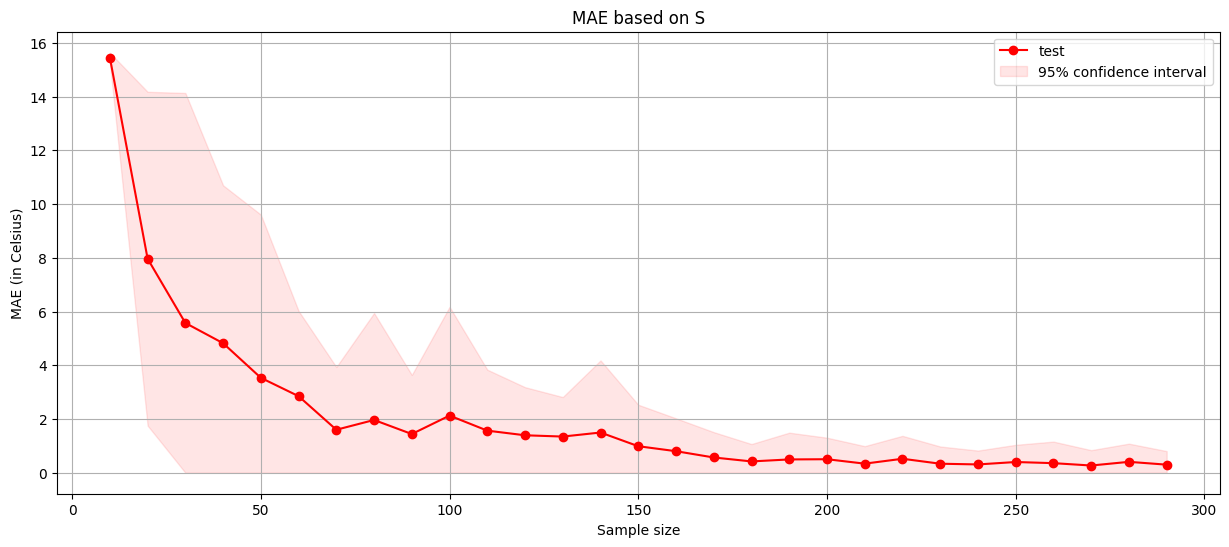

In [ ]:
MAE_upperbounds = [MAE_test_unstandardized[i] + 1.96*MAE_test_unstandardized_stds[i] for i in range(len(MAE_test_unstandardized))]
MAE_lowerbounds = [MAE_test_unstandardized[i] - 1.96*MAE_test_unstandardized_stds[i] for i in range(len(MAE_test_unstandardized))]

for i in range(len(MAE_lowerbounds)):
  if MAE_lowerbounds[i] < 0:
    MAE_lowerbounds[i] = 0

plt.figure(figsize=(15,6))
#plt.plot(sample_sizes, MAE_train, 'o-', color='green', label='train')
plt.plot(sample_sizes, MAE_test_unstandardized, 'o-', color='red', label='test')

plt.fill_between(
    sample_sizes.ravel(),
    MAE_upperbounds,
    MAE_lowerbounds,
    alpha=0.1,
    color = 'red',
    label=r"95% confidence interval",
)


plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel('MAE (in Celsius)')
plt.title('MAE based on S')
plt.show()

Based off these three
 graphs, it appears that the optimal sample size is around 200 with 14 variables. I wonder if reducing the number of variables would require more or less samples.

# TRYING 1-5 PARAMETERS

Maybe this will help the model

In [ ]:
X = data[['t_final', 'h_tile', 'h_Ti', 'rho_tile', 'rho_Ti', 'cp_tile', 'cp_Ti',
       'k_tile', 'k_Ti', 'emissivity', 'M_inf', 'p_inf', 'T_inf',
       'fudge_factor']]
y = data[['simulation_values']]

In [ ]:
corr = []

# for col in X.columns:
    plt.scatter(X[col], y)
    corrcoef = np.corrcoef(np.asarray(X[col]),np.asarray(y['simulation_values']))[0][1]
    corr.append(corrcoef)
    plt.title(col)
    plt.show()

print(corr)

# finding linear corr btwn IV's and DV

# Just using 5 variables
h_tile, rho_tile, cp_tile, k_tile, m_inf

In [ ]:
sample_sizes = np.arange(10,300,10)

mae_train = []
mae_test = []
mae_train_5 = []
mae_test_5 = []

for s in sample_sizes:
  """
  This function iterates through a tuple of sample_sizes to see MAE differences.
  """
  indexes = random.sample(range(0, 1000), s)
  sample_data = data.loc[indexes]

  X_5 = sample_data.loc[:,[1,3,5,7,10]]
  # X = sample_data[['t_final', 'h_tile', 'h_Ti', 'rho_tile', 'rho_Ti', 'cp_tile', 'cp_Ti',
  #      'k_tile', 'k_Ti', 'emissivity', 'M_inf', 'p_inf', 'T_inf','fudge_factor']]
  X = sample_data.loc[:,0:13]

  #y = sample_data[['simulation_values']]

  y = sample_data.loc[:,14]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y, test_size=0.2, random_state=42)

  # kernel = ConstantKernel(constant_value=1)

  kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))

  # kernel = RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-05, 1e5), alpha_bounds=(1e-05, 100000.0))

  # kernel = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-05, 100000.0))

  # kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=1.5)

  gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

  # 14 variables

  gpr.fit(X_train, y_train)

  y_train_pred = gpr.predict(X_train)
  y_test_pred = gpr.predict(X_test)

  mae_train.append(mean_absolute_error(y_train, y_train_pred))
  mae_test.append(mean_absolute_error(y_test, y_test_pred))

  # 5 variables

  gpr.fit(X_train_5, y_train_5)

  y_train_pred_5 = gpr.predict(X_train_5)
  y_test_pred_5 = gpr.predict(X_test_5)

  mae_train_5.append(mean_absolute_error(y_train_5, y_train_pred_5))
  mae_test_5.append(mean_absolute_error(y_test_5, y_test_pred_5))

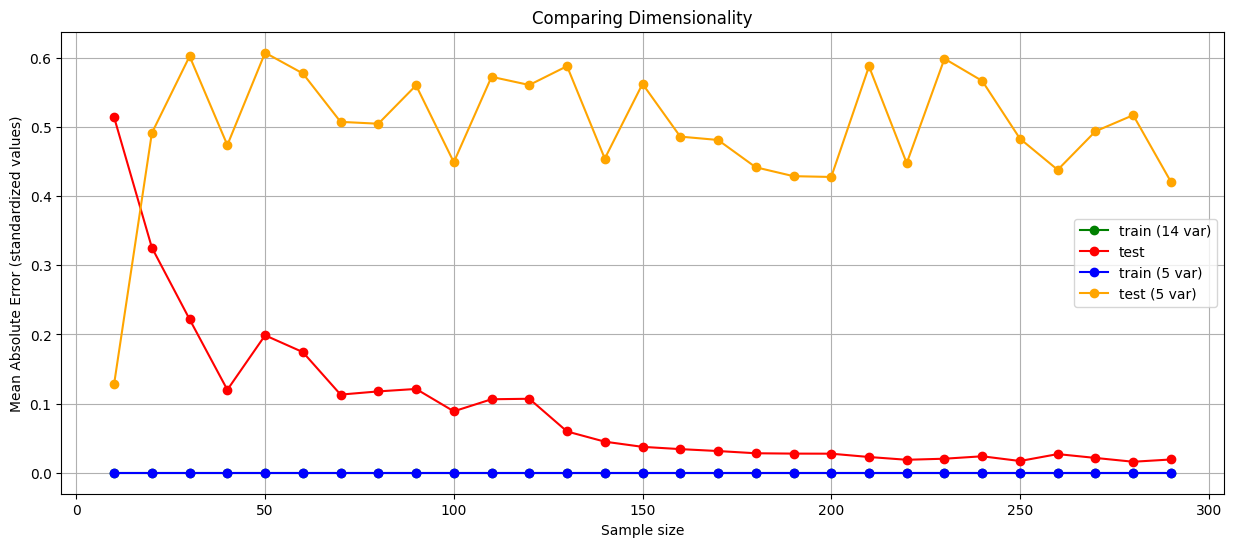

In [ ]:
# Graphing MAE with 3 plots to compare 5 var vs 14 var

plt.figure(figsize=(15,6))
plt.plot(sample_sizes, mae_train, 'o-', color='green', label='train (14 var)')
plt.plot(sample_sizes, mae_test, 'o-', color='red', label='test')
plt.plot(sample_sizes, mae_train_5, 'o-', color='blue', label='train (5 var)')
plt.plot(sample_sizes, mae_test_5, 'o-', color='orange', label='test (5 var)')

plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel('Mean Absolute Error ')
plt.title('Comparing Dimensionality')
plt.show()

In [ ]:
# NEED TO TRANSLATE MAE OF Z-SCORE TO CELSIUS

# Testing to see how models perform without each IV



In [ ]:
for i in range(len(data.columns)-1):
  df = data.drop(i, axis=1)
  sample_test_func(df)

In [ ]:
noise = np.random.normal(0,1,100)


In [ ]:
X = data.loc[:,0:13]
y = data.loc[:,14]

# Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(X)
X_pca = pca.transform(X)
X_pca = pd.DataFrame(X_pca)